# 房價預測

## 1. 載入相關套件

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 載入 Boston 房價資料集

In [2]:
# 讀取數據集
# 這是波士頓房價數據集
# 來源: https://archive.ics.uci.edu/ml/machine-learning-databases/housing/
# 讀取文字檔(.data)方式

with open('./data/housing.data', encoding='utf8') as f: # 開啟檔案, with 會自動關閉檔案與釋放記憶體
    data = f.readlines() # 逐行讀取, readlines 讀出來的資料是字串
    
all_fields = [] # 所有欄位資料
for line in data: # 逐行處理, 讀取每一行(1個字串)
    line2 = line[1:].replace('   ', ' ').replace('  ', ' ') # 清理多餘空格,將3個空白換成1個空白.將2個空白換成1個空白,可以寫成一行
    # line[1:] 是去除第一個字元,因為有些行的開頭有空白
    # line2 = line.strip() # 去除前後空白
    # print(f'line2={line2}') # 印出清理後的字串

    fields = [] # 單筆欄位資料
    for item in line2.split(' '): # 以空白分割
        #if item.strip() != '': # 去除空白後,如果不是空字串,才加入欄位資料
        fields.append(float(item.strip())) # 去除前後空白,將字串轉成浮點數
        # fields.append(item.strip()) # 去除前後空白
        # fields.append(int(item.strip())) # 去除前後空白並轉成整數
        # fields.append(item) # 不去除前後空白
        if len(fields) == 14: # 如果欄位數量已經是14個,就停止處理
            all_fields.append(fields) # 加入所有欄位資料
df = pd.DataFrame(all_fields) # 轉成DataFrame
df.columns = 'CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV'.split(',') # 設定欄位名稱
# CRIM: 犯罪率
# ZN: 住宅用地比例
# INDUS: 非零售業比例
# CHAS: 是否靠近查爾斯河 (1: 是, 0: 否)
# NOX: 一氧化氮濃度
# RM: 每戶平均房間數
# AGE: 1940年前建成的自住單位比例
# DIS: 距離五個波士頓就業中心的加權距離
# RAD: 路線可達性指數
# TAX: 每一萬元的全值財產稅率
# PTRATIO: 城鎮師生比例
# B: 1000(Bk - 0.63)^2, Bk為城鎮中黑人比例
# LSTAT: 低收入人口比例
# MEDV: 房屋中位數 (單位: 千美元) (目標變數)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## 2. 資料清理、資料探索與分析

In [3]:
# 觀察資料集彙總資訊
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


In [4]:
# 描述統計量
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,1.716290,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,2.653510,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.250895,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,2.326717,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,9.966540,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [5]:
# 是否有含遺失值(Missing value)
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## 繪圖

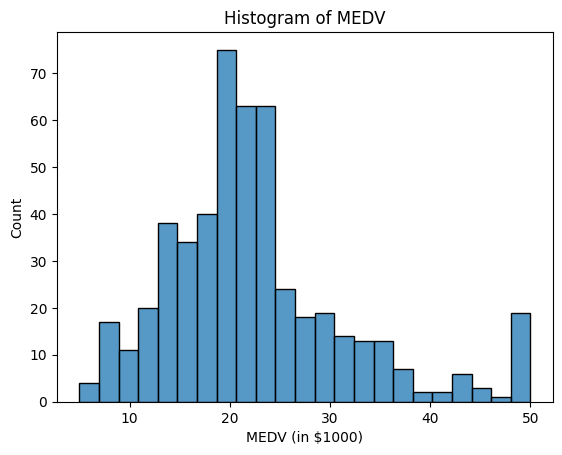

In [6]:
# 直方圖
import seaborn as sns

X, y = df.drop('MEDV', axis=1).values, df.MEDV.values # 特徵矩陣與目標變數  
sns.histplot(x=y) # 直方圖
plt.title('Histogram of MEDV')
plt.xlabel('MEDV (in $1000)')
plt.ylabel('Count')
plt.show()

## 3. 不須進行特徵工程

## 4. 資料分割

In [7]:
# 資料分割
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2,
                                                    random_state=42
                                                    )

# 查看陣列維度
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## 特徵縮放

In [8]:
scaler = StandardScaler() # 標準化
X_train_std = scaler.fit_transform(X_train) # 訓練集標準化
X_test_std = scaler.transform(X_test) # 測試集標準化, 注意: 只能用訓練集的參數來轉換測試集

## 5. 選擇演算法(模型)

In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # 建立線性迴歸模型

## 6. 模型訓練

In [10]:
model.fit(X_train_std, y_train) # 訓練模型

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [ ]:
print(model.coef_) # 迴歸係數w, 數值愈小代表重要性愈小, 挑選w數值愈大愈好
# model.intercept_ # 截距b

[-0.48449946  0.61333744  0.33762724  0.76984022 -1.81759222  3.21268003
 -0.20712638 -2.89490079  2.01060971 -1.72336049 -2.017698    1.23586954
 -3.71081796]


## 7. 模型評分

In [ ]:
# R2、MSE、MAE
y_pred = model.predict(X_test_std) # 預測
print(model.score(X_test_std, y_test))
print(f'R2 = {r2_score(y_test, y_pred)*100:.2f}') 
print(f'MSE = {mean_squared_error(y_test, y_pred)}') 
print(f'MAE = {mean_absolute_error(y_test, y_pred)}') 

0.6631666417736528
R2 = 66.32
MSE = 24.701264453334332
MAE = 3.1791314554839687


In [13]:
# 權重
model.coef_ # 迴歸係數w

array([-0.48449946,  0.61333744,  0.33762724,  0.76984022, -1.81759222,
        3.21268003, -0.20712638, -2.89490079,  2.01060971, -1.72336049,
       -2.017698  ,  1.23586954, -3.71081796])

In [14]:
model.intercept_ # 截距b

np.float64(22.79653465346538)

In [15]:
a = df.columns[np.argmax(np.abs(model.coef_))] # 找出對目標變數影響最大的特徵名稱,LSTAT是低收入人口比例
b = df.columns[np.argmax(model.coef_)] # 找出對目標變數正向影響最大的特徵名稱,RM是房間數   
print(a, b)

LSTAT RM


## 8. 模型評估，暫不進行

## 9. 模型佈署

儲存權重w

In [16]:
# 模型存檔
import joblib

joblib.dump(model, 'lr_model.joblib') # 存模型
joblib.dump(scaler, 'lr_scaler.joblib') # 存標準化物件

['lr_scaler.joblib']

## 10. 模型預測，請參見 03_ linear_regression_prediction.py